# Policy Gradient-Based Deterministic Optimal Savings

Author: [John Stachurski](https://johnstachurski.net)

## Introduction

In this notebook we solve a deterministic infinite horizon optimal savings
problem using policy gradient ascent with JAX. 

Each policy is represented as a fully connected feed forward neural network.

Utility takes the CRRA form $u(c) = c^{1-\gamma} / (1-\gamma)$ and the discount factor is $\beta$.

Wealth evolves according to 

$$
    w' = R (w - c) + Y'
$$

where $R > 0$ is the gross interest rate and $Y'$ is an IID lognormal draw.  

To ensure stability we check that $\beta R^{1-\gamma} < 1$.

Initial wealth $w_0$ is fixed at 1.0, so the objective function is

$$
    \max_{\sigma \in \Sigma} v_\sigma(w_0)
    \quad \text{with} \quad w_0 := 1.0
$$

Here 

* $\Sigma$ is the set of all feasible policies and
* $v_\sigma(w)$ is the lifetime value of following stationary policy $\sigma$, given initial wealth $w$.

We begin with some imports

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import optax
import matplotlib.pyplot as plt
from functools import partial
from typing import NamedTuple

## Set up

We use a class called `Model` to store model parameters.

In [2]:
class Model(NamedTuple):
    """
    Stores parameters for the model.

    """
    γ: float = 0.2    # Utility parameter
    β: float = 0.96   # Discount factor
    R: float = 1.01   # Gross interest rate
    μ: float = 0.0    # income location parameter
    ν: float = 0.4    # income volatility parameter

We use a class called `LayerParams` to store parameters representing a single
layer of the neural network.

In [3]:
class LayerParams(NamedTuple):
    """
    Stores parameters for one layer of the neural network.

    """
    W: jnp.ndarray     # weights
    b: jnp.ndarray     # biases

The next class stores some fixed values that form part of the network training
configuration.

In [4]:
class Config:
    """
    Configuration and parameters for training the neural network.

    """
    seed = 42                       # Seed for network initialization
    epochs = 1500                   # No of training epochs
    layer_sizes = 1, 32, 32, 32, 1  # Network layer sizes
    init_lr = 0.01                  # Learning rate schedule parameter
    min_lr = 0.001                  # Learning rate schedule parameter
    warmup_steps = 100              # Learning rate schedule parameter
    decay_steps = 300               # Learning rate schedule parameter

The following function initializes a single layer of the network using Le Cun
initialization.

(Le Cun initialization is thought to pair well with `selu` activation.)

In [5]:
def initialize_layer(in_dim, out_dim, key):
    """
    Initialize weights and biases for a single layer of a the network.

    """
    s = jnp.sqrt(1.0 / in_dim)
    W = jax.random.normal(key, (in_dim, out_dim)) * s
    b = jnp.ones((out_dim,))
    return LayerParams(W, b)

The next function builds an entire network, as represented by its parameters, by
initializing layers and stacking them into a list.

In [6]:
def initialize_network(key, layer_sizes):
    """
    Build a network by initializing all of the parameters.
    A network is a list of LayerParams instances, each 
    containing a weight-bias pair (W, b).

    """
    params = []
    # For all layers but the output layer
    for i in range(len(layer_sizes) - 1):
        # Build the layer 
        key, subkey = jax.random.split(key)
        layer = initialize_layer(
            layer_sizes[i],      # in dimension for layer
            layer_sizes[i + 1],  # out dimension for layer
            subkey 
        )
        # And add it to the parameter list
        params.append(layer)

    return params

Now we provide a function to do a forward pass through the network, given the
parameters.

In [7]:
def forward(params, w):
    """
    Evaluate neural network policy: maps a given wealth level w to a rate of
    consumption c/w by running a forward pass through the network.

    Assumes w is an array.

    """
    σ = jax.nn.selu          # Activation function
    x = w.reshape(-1, 1)     # Shape: (batch_size, 1)
    # Forward pass through network, without the last step
    for W, b in params[:-1]:
        x = σ(x @ W + b)
    # Complete with sigmoid activation for consumption rate
    W, b = params[-1]
    x = jax.nn.sigmoid(x @ W + b)
    # Return squeezed output (flatten array)
    return x.squeeze()

We use CRRA utility.

In [8]:
def u(c, γ):
    """ Utility function. """
    c = jnp.maximum(c, 1e-10)
    return c**(1 - γ) / (1 - γ)

The next function approximates lifetime value associated with a given policy, as
represented by the parameters of a neural network.

In [9]:
@partial(jax.jit, static_argnames=('cross_section_size', 'path_length'))
def compute_lifetime_value(
        key,
        params, 
        model, 
        cross_section_size, 
        path_length
    ):
    """
    Compute the lifetime value of a path generated from

    1. the policy associated with params 
    2. the initial condition w_0 = 1.

    """
    γ, β, R, μ, σ = model
    initial_w = jnp.full(cross_section_size, 1.0)  # Start everyone at 1.0

    def update(t, loop_state):
        # Unpack and compute consumption given current wealth
        key, w, value, discount = loop_state
        consumption_rate = forward(params, w)
        c = consumption_rate * w
        # Update loop state and return it
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (cross_section_size,))
        Y = jnp.exp(μ + σ * Z)
        w = R * (w - c) + Y
        value = value + discount * u(c, γ) 
        discount = discount * β
        new_loop_state = key, w, value, discount
        return new_loop_state
    
    initial_value = jnp.zeros(cross_section_size)
    initial_discount = 1.0
    initial_state = key, initial_w, initial_value, initial_discount
    final_key, final_w, final_value, discount = jax.lax.fori_loop(
        0, path_length, update, initial_state
    )
    return jnp.mean(final_value)

Here's the loss function we will minimize.


In [10]:
def loss_function(
        params,
        model,
        cross_section_size=5_000,
        path_length=500,
        seed=42):
    """
    Loss is the negation of the lifetime value of the policy
    identified by `params`.

    """
    key = jax.random.PRNGKey(seed)
    loss = - compute_lifetime_value(
        key, params, model, cross_section_size, path_length
    )
    return loss

We create a standard Optax learning rate scheduler, which controls the time path
of the learning parameter over the process of gradient descent.

In [11]:
def create_lr_schedule():
    warmup_fn = optax.linear_schedule(
        init_value=0.0,
        end_value=Config.init_lr,
        transition_steps=Config.warmup_steps
    )
    
    decay_fn = optax.exponential_decay(
        init_value=Config.init_lr,
        transition_steps=Config.decay_steps,
        decay_rate=0.5,
        end_value=Config.min_lr
    )
    
    return optax.join_schedules(
        schedules=[warmup_fn, decay_fn],
        boundaries=[Config.warmup_steps]
    )

## Train and solve 

First we create an instance of the model and unpack names

In [12]:
model = Model()
γ, β, R, μ, σ = model
seed, epochs = Config.seed, Config.epochs
layer_sizes = Config.layer_sizes

We test stability.

In [13]:
assert β * R**(1 - γ) < 1, "Parameters fail stability test."

Let's now create a learning rate schedule and set up the Optax minimizer, using
[Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).

In [14]:
lr_schedule = create_lr_schedule()
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Gradient clipping for stability
    optax.adam(learning_rate=lr_schedule)
)

We initialize the parameters in the neural network and the state of the
optimizer.

In [15]:
key = random.PRNGKey(seed)
params = initialize_network(key, layer_sizes)
opt_state = optimizer.init(params)

Now let's train the network.

In [16]:
value_history = []
grad_norm_history = []
key = random.PRNGKey(seed)
for i in range(epochs):

    # Generate new random seed for this iteration
    key, subkey = random.split(key)
    iteration_seed = int(random.randint(subkey, (), 0, 2**31 - 1))

    # Compute value and gradients at existing parameterization
    loss, grads = jax.value_and_grad(loss_function)(params, model, seed=iteration_seed)
    lifetime_value = - loss
    value_history.append(lifetime_value)

    # Compute gradient norm
    grad_norm = jnp.sqrt(sum(jnp.sum(g.W**2) + jnp.sum(g.b**2) for g in grads))
    grad_norm_history.append(grad_norm)

    # Update parameters using optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    if i % 100 == 0:
        print(f"Iteration {i}: Value = {lifetime_value:.4f}, Grad Norm = {grad_norm:.6f}")


print(f"\nFinal value: {value_history[-1]:.4f}")

Iteration 0: Value = 32.6480, Grad Norm = 2.978794


Iteration 100: Value = 32.9265, Grad Norm = 0.120630


Iteration 200: Value = 32.9344, Grad Norm = 0.289526


Iteration 300: Value = 32.9458, Grad Norm = 0.006193


Iteration 400: Value = 32.9212, Grad Norm = 0.024778


Iteration 500: Value = 32.9383, Grad Norm = 0.009369


Iteration 600: Value = 32.9333, Grad Norm = 0.024112


Iteration 700: Value = 32.9510, Grad Norm = 0.077527


Iteration 800: Value = 32.8811, Grad Norm = 0.012650


Iteration 900: Value = 32.9105, Grad Norm = 0.006230


Iteration 1000: Value = 32.9370, Grad Norm = 0.024003


Iteration 1100: Value = 32.9432, Grad Norm = 0.015299


Iteration 1200: Value = 32.9347, Grad Norm = 0.014077


Iteration 1300: Value = 32.9338, Grad Norm = 0.001753


Iteration 1400: Value = 32.8911, Grad Norm = 0.003646



Final value: 32.9133


First we plot the evolution of lifetime value over the epochs.

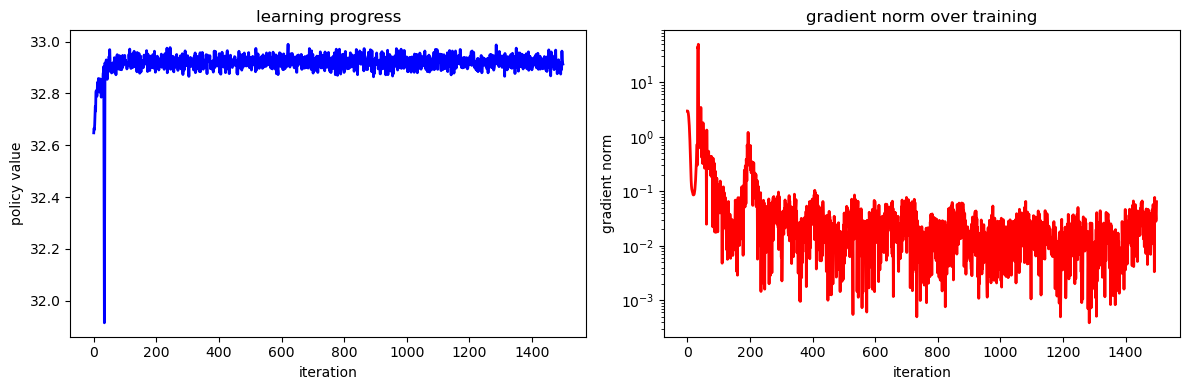

In [17]:
# Plot learning progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(value_history, 'b-', linewidth=2)
ax1.set_xlabel('iteration')
ax1.set_ylabel('policy value')
ax1.set_title('learning progress')

ax2.plot(grad_norm_history, 'r-', linewidth=2)
ax2.set_xlabel('iteration')
ax2.set_ylabel('gradient norm')
ax2.set_title('gradient norm over training')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

Next we plot the optimal consumption and savings policies.

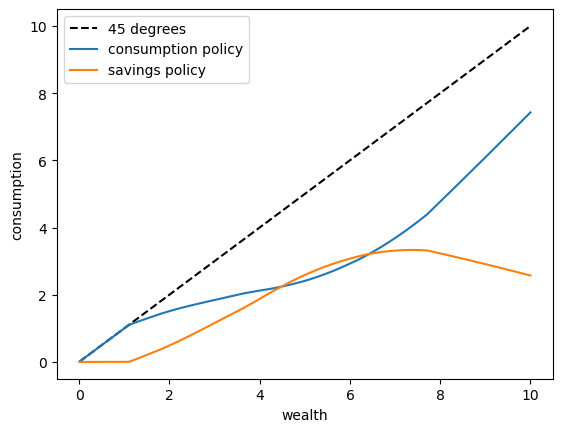

In [18]:
w_grid = jnp.linspace(0.01, 10.0, 1000)
consumption_rate = forward(params, w_grid)
consumption = consumption_rate * w_grid
savings = w_grid - consumption
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, linestyle='--', color='k', label='45 degrees')
ax.plot(w_grid, consumption, label='consumption policy')
ax.plot(w_grid, savings, label='savings policy')
ax.set_xlabel('wealth')
ax.set_ylabel('consumption')
ax.legend()
plt.show()